**Implementation of a Trinomial tree model for American option**

(A)

*The algorithm*

We set the notation that:
\begin{align*}
s^n_k=S_0 u^{n
-k},\qquad n=0,1,...,N\quad k=0,1,...,2n
\end{align*}
is the $k^{th}$ possible stock price level at time $n$, $V^n_k$ and $g^n_k$is the time-$n$ fair value and intrinsic value of the American option respectively when the stock price is $s^n_k$. 

Then the pricing procedure is:

1.   Compute the option price at the terminal time $N$ which is simply its intrinsic value:
		\begin{align}
		V^N_k=g^n_k = g(S_0 u^{N-k}) \quad \text{for each }k=0,1,...,2N
		\end{align}

2.   Loop backward in time: for $n=N-1,N-2,...,0$, compute
		\begin{align*}
		V^{n}_k= \max\{g^n_k, e^{-r\triangle t}[q_uV^{n+1}_{k} + q_mV^{n+1}_{k+1} + q_dV^{n+1}_{k+2}]\}\quad\text{for each }k=0,1,...,2n
		\end{align*}
  
3.   The required time-zero option value is $V^0_0$

(B)

Load the usual packages

In [ ]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt

Implementation of the above pricing algorithm:

In [ ]:
def AmeriTrinomialTree(s0, u, qu, qm, qd, R, N, payoff):
        
    # Create empty arrays to store the stock price and option value at each node
    VA = np.zeros((2*N+1, N+1))
    VE = np.zeros((2*N+1, N+1))
    S = np.zeros((2*N+1, N+1))
    
    # Set up S[k,n] = s0 * u^(n-k)
    for t in range(N+1):
      S[0:2*t+1, t] = s0 * u**np.arange(t, -t-1, -1)
    
    # Compute the option price at terminal time
    VA[:,N] = payoff(S[:,N])
    VE[:,N] = payoff(S[:,N])
    
    # Loop backward in time
    for t in reversed(range(N)):
        VA[0:2*t+1, t] = np.maximum(payoff(S[0:2*t+1, t]), (qu * VA[0:2*t+1,t+1] + qm * VA[1:2*t+2,t+1] + qd * VA[2:2*t+3, t+1]) / R)
        VE[0:2*t+1, t] = (qu * VE[0:2*t+1,t+1] + qm * VE[1:2*t+2,t+1] + qd * VE[2:2*t+3, t+1]) / R

    return VA, VE, S     

*Choosing the tree parameters*

There are a number of ways we can choose the tree parameters. We choose the Kamrad-Ritchken parametrisation here:
	\begin{align*}
	&q_u=\frac{1}{2\lambda^2} + \frac{(r-\frac{\sigma^2}{2})\sqrt{\triangle t}}{2\lambda \sigma}, \quad q_m = 1 - \frac{1}{\lambda^2}, \quad q_d=\frac{1}{2\lambda^2} - \frac{(r-\frac{\sigma^2}{2})\sqrt{\triangle t}}{2\lambda \sigma},\\
\\
&u=e^{\lambda \sigma \sqrt{\triangle t}},\quad m = 1, \quad d=e^{-\lambda \sigma \sqrt{\triangle t}}.
	\end{align*}

In [ ]:
def GetTrinomialKRPara(lamb, r, dt, sigma):
  u = np.exp(lamb * sigma * np.sqrt(dt))
  R = np.exp(r * dt)
  qu = 1/(2*lamb**2) + (r-sigma**2/2)*np.sqrt(dt)/(2*lamb*sigma)
  qm = 1 - 1/lamb**2
  qd = 1 - qu - qm
  return u, qu, qm, qd, R

Now we try to use a 500-period tree to price an American call option which payoff function is $(S_T-K)^{+}$. Parameters are: number of peroid $N=500$, strike price $K=100$, maturity $T=1$ year, interest rate $r=1\%$ and volatility $\sigma=20\%$.

In [ ]:
r, T, sigma, K, lamb = 0.01, 1, 0.2, 100, 1.25   
N = 500                                          
CallPayoff = lambda x : np.maximum(x - K, 0)   
s0_range = np.arange(50,200,1)
Intrinsicv =  np.zeros(len(s0_range))
TrinomialAmerPx = np.zeros(len(s0_range))
TrinomialEuroPx = np.zeros(len(s0_range))

for i, s0 in enumerate(s0_range):
  u, qu, qm, qd, R = GetTrinomialKRPara(lamb, r, T/N, sigma)     
  VA, VE, S = AmeriTrinomialTree(s0, u, qu, qm, qd, R, N, CallPayoff)
  TrinomialAmerPx[i] = VA[0,0]      
  TrinomialEuroPx[i] = VE[0,0]
  Intrinsicv[i] = CallPayoff(s0)

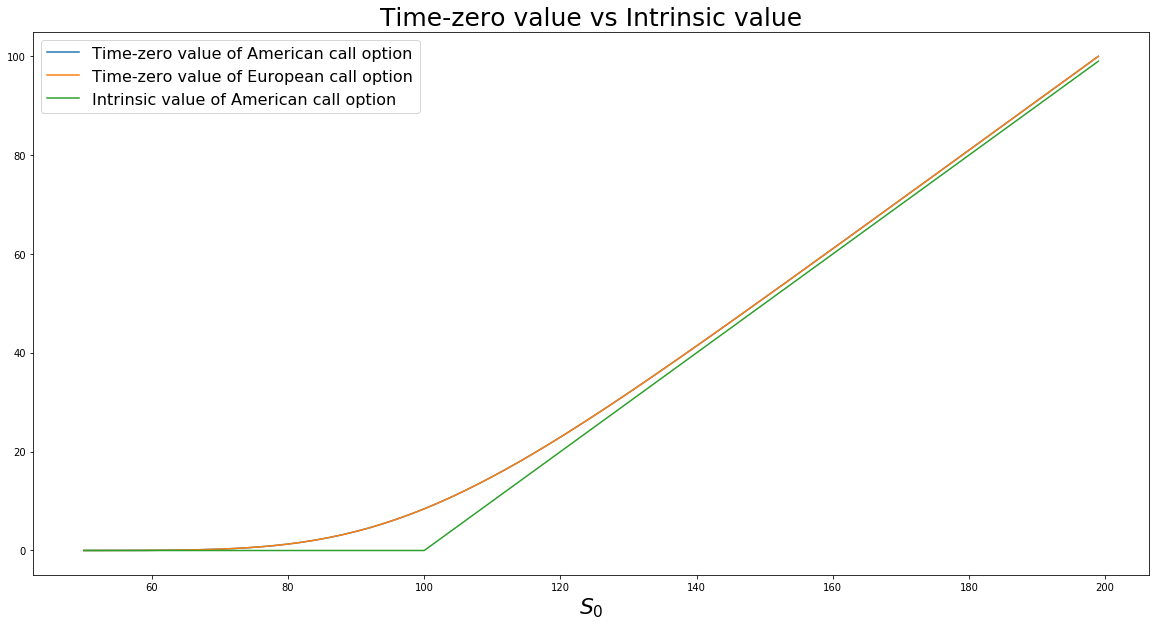

In [ ]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(s0_range, TrinomialAmerPx, label='Time-zero value of American call option')
ax.plot(s0_range, TrinomialEuroPx, label='Time-zero value of European call option')
ax.plot(s0_range, Intrinsicv, label='Intrinsic value of American call option')
ax.set_xlabel('$S_0$', fontsize = 22)
ax.set_title('Time-zero value vs Intrinsic value', fontsize = 25 )

ax.legend(fontsize = 16)

As we can see, with the same parameters without dividends, American call option has the same value with European call option.

Time-zero fair value of an American call option is always higher than its intrinsic value, which is consistent with the recursion $V^{n}= max\{g(S_n), e^{-r\triangle t}E_Q[V^{n+1}|\mathcal{F}_n]\}\quad\text{for each }n=0,1,...,N-1$ 缺少N时刻表达式，这里格式不好打

Early exercise is optimal at time-zero if and only if the intrinsic value is larger than the continuation value, which is equivalent to that fair value is equal to intrinsic value. We do not exercise the option when its value is zero, in the above gragh, due to the fact that the fair value of an American option without dividends is always greater than its intrinsic value, so the optimal early exercise strategy is to never exercise the option.

(C)

Now we try to use a 500-period tree to price an American put option which payoff function is $(K-S_T)^{+}$. Parameters are: number of peroid $N=500$, strike price $K=100$, maturity $T=1$ year, interest rate $r=1\%$ and volatility $\sigma=20\%$.

In [ ]:
r, T, sigma, K, lamb = 0.01, 1, 0.2, 100, 1.25   
N = 500                                          
PutPayoff = lambda x : np.maximum(K - x, 0)  
s0_range = np.arange(50,200,1)
Intrinsicv =  np.zeros(len(s0_range))
TrinomialAmerPx = np.zeros(len(s0_range))
TrinomialEuroPx = np.zeros(len(s0_range))

for i, s0 in enumerate(s0_range):
  u, qu, qm, qd, R = GetTrinomialKRPara(lamb, r, T/N, sigma)     
  VA, VE, S = AmeriTrinomialTree(s0, u, qu, qm, qd, R, N, PutPayoff)
  TrinomialAmerPx[i] = VA[0,0]      
  TrinomialEuroPx[i] = VE[0,0]
  Intrinsicv[i] = PutPayoff(s0)

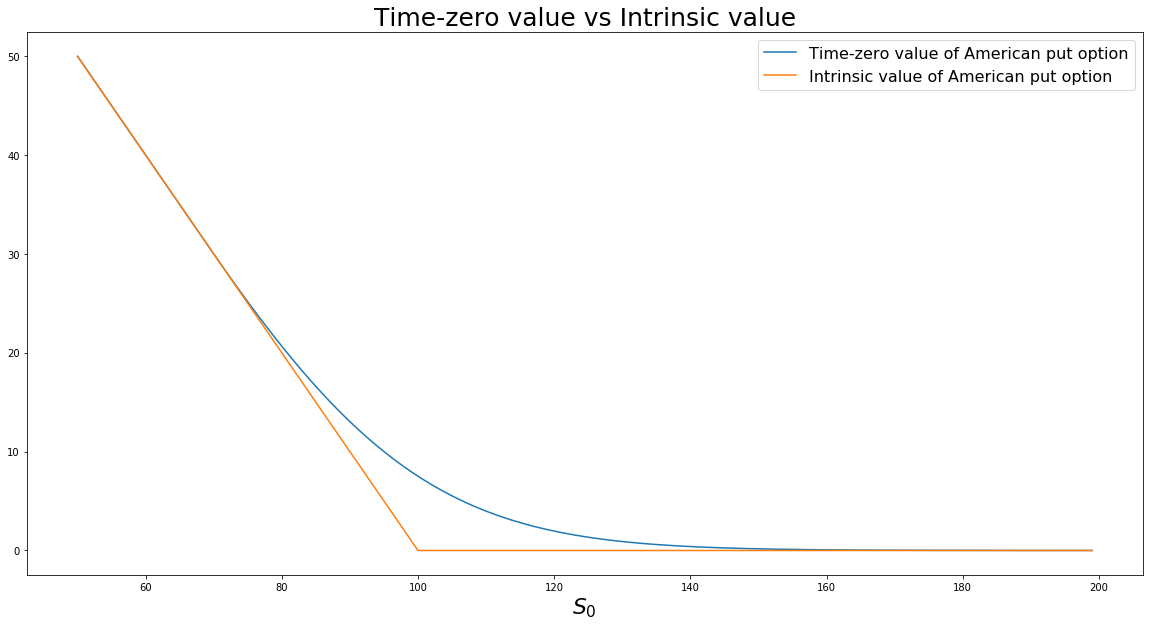

In [ ]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(s0_range, TrinomialAmerPx, label='Time-zero value of American put option')
#ax.plot(s0_range, TrinomialEuroPx, label='Time-zero value of European put option')
ax.plot(s0_range, Intrinsicv, label='Intrinsic value of American put option')
ax.set_xlabel('$S_0$', fontsize = 22)
ax.set_title('Time-zero value vs Intrinsic value', fontsize = 25)
ax.legend(fontsize = 16)

Unlike the above, with the same parameters without dividends, American put option has higher value than European put option.

Time-zero fair value of an American put option is always higher or equal to its intrinsic value, while the European put option can be lower than the intrinsic value.

As before, early exercise is optimal at time-zero if and only if the fair value is equal to intrinsic value. In our case, the optimal early exercise strategy is to exercise the option at time-zero when the initial stock price $S_0$ is from 50 to around 76( acqually it can be from 0 to around 76).

We are going to vary $\sigma$ and $r$ respectively to explore how the early exercise strategy changes. To check the influence of initial stock price on this mechanism, we work with different $S_0$.

First of all, we vary $\sigma$ from $0\%$ to $100\%$ with stepsize $5\%$.

In [ ]:
r, T, K, lamb = 0.01, 1, 100, 1.25   
N = 500                                          
PutPayoff = lambda x : np.maximum(K - x, 0)  
sigma_range = np.arange(0.05, 1.05, 0.05)
TrinomialPxs_sigma = []
Intrinsicvs_sigma = []
num_trials = 20

for j in range(num_trials):
  TrinomialPx = np.zeros(len(sigma_range))
  Intrinsicv =  np.zeros(len(sigma_range))
  s0 = 10*(j+1)
  for i, sigma in enumerate(sigma_range):
    u, qu, qm, qd, R = GetTrinomialKRPara(lamb, r, T/N, sigma)     
    VA, VE, S = AmeriTrinomialTree(s0, u, qu, qm, qd, R, N, PutPayoff)
    TrinomialPx[i] = VA[0,0]      
    Intrinsicv[i] = PutPayoff(s0)
  TrinomialPxs_sigma.append(TrinomialPx)
  Intrinsicvs_sigma.append(Intrinsicv)

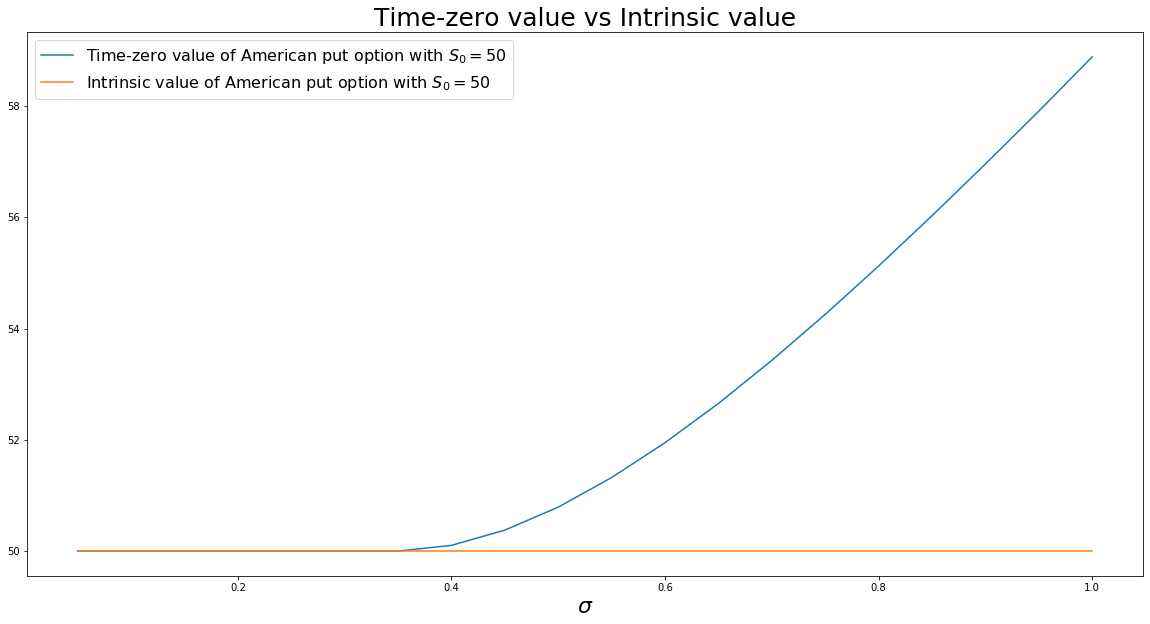

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(sigma_range, TrinomialPxs_sigma[4], label='Time-zero value of American put option with $S_0='+str(10*(4+1))+'$')
ax.plot(sigma_range, Intrinsicvs_sigma[4], label='Intrinsic value of American put option with $S_0='+str(10*(4+1))+'$')
ax.set_xlabel('$\sigma$', fontsize = 22)
ax.set_title('Time-zero value vs Intrinsic value', fontsize = 25)
ax.legend(fontsize = 16)

We fix $S_0=50$.

When $\sigma$ is small (below 36% in our case), the stock price is likely to stay at 50 among the whole peroid, so the optimal early exercise strategy is to exercise the option at time-zero. 

When $\sigma$ is greater than 36% in our case, the possible fluctuation of stock price will be large enough to change the optimal early exercise strategy at time-zero, i.e. to not exercise at time-zero.

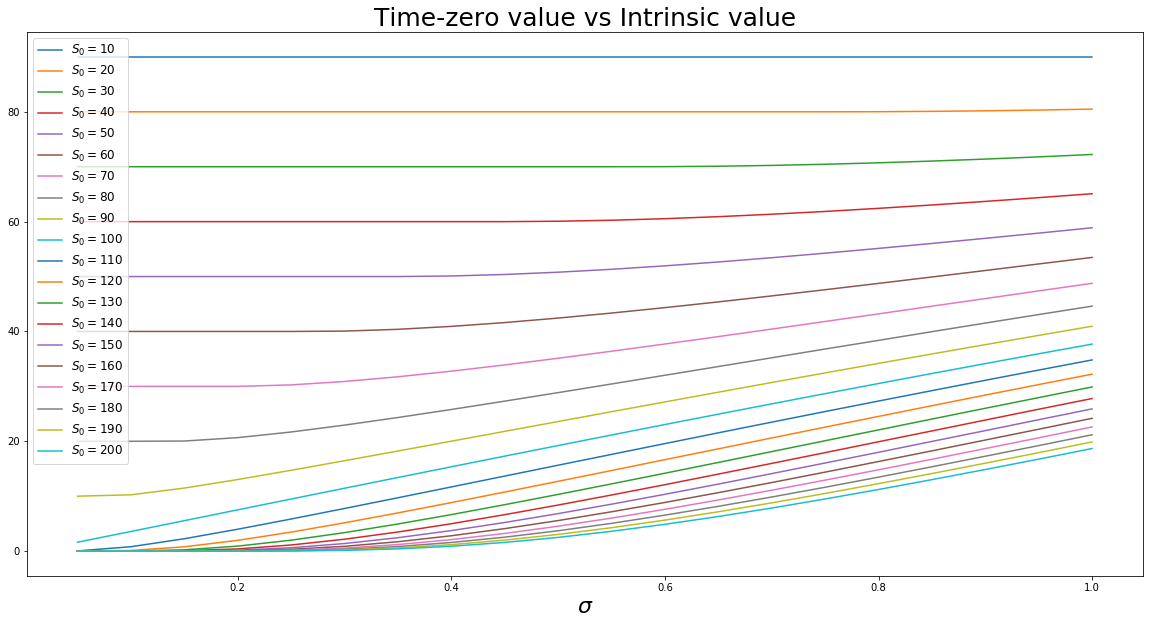

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
for j in range(num_trials):
  ax.plot(sigma_range, TrinomialPxs_sigma[j], label='$S_0='+str(10*(j+1))+'$')
  #ax.plot(sigma_range, Intrinsicvs_sigma[j], label='Intrinsic value of American put option with $S_0='+str(10*(j+1))+'$')
ax.set_xlabel('$\sigma$', fontsize = 22)
ax.set_title('Time-zero value vs Intrinsic value', fontsize = 25)
ax.legend(fontsize = 12)

In [ ]:
sigma, T, K, lamb = 0.2, 1, 100, 1.25   
N = 500                                          
PutPayoff = lambda x : np.maximum(K - x, 0)  
r_range = np.arange(0, 0.3, 0.01)
TrinomialPxs_r = []
Intrinsicvs_r = []
num_trials = 20

for j in range(num_trials):
  TrinomialPx = np.zeros(len(r_range))
  Intrinsicv =  np.zeros(len(r_range))
  s0 = 10*(j+1)
  for i, r in enumerate(r_range):
    u, qu, qm, qd, R = GetTrinomialKRPara(lamb, r, T/N, sigma)     
    VA, VE, S = AmeriTrinomialTree(s0, u, qu, qm, qd, R, N, PutPayoff)
    TrinomialPx[i] = VA[0,0]      
    Intrinsicv[i] = PutPayoff(s0)
  TrinomialPxs_r.append(TrinomialPx)
  Intrinsicvs_r.append(Intrinsicv)

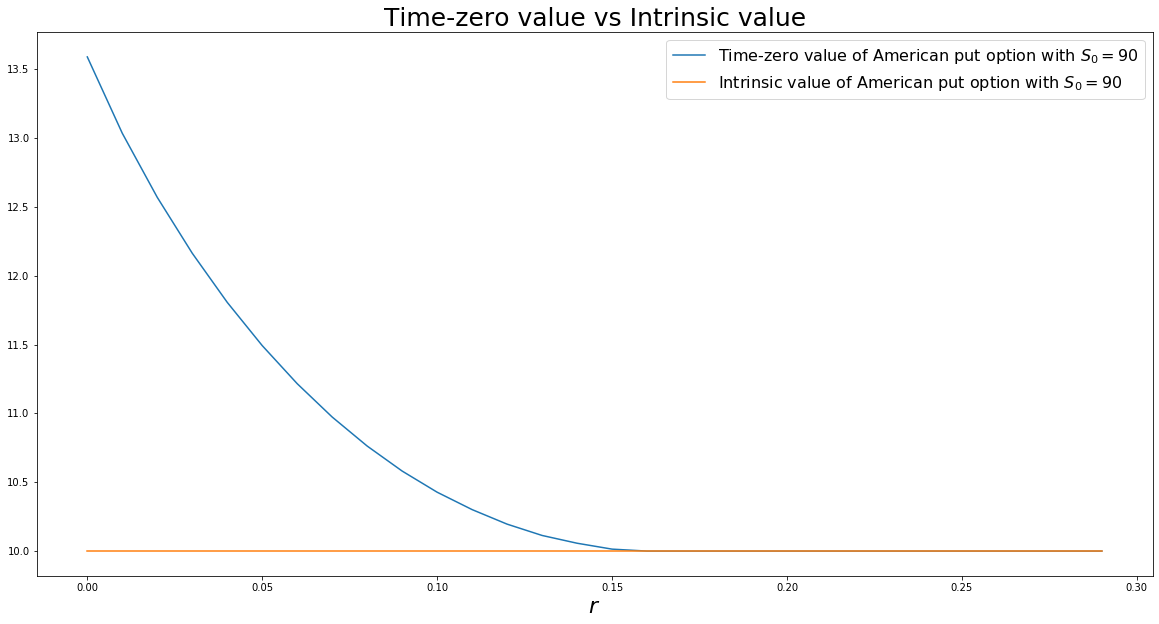

In [ ]:
ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(useOffset=False, style='plain')
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(r_range, TrinomialPxs_r[8], label='Time-zero value of American put option with $S_0='+str(10*(8+1))+'$')
ax.plot(r_range, Intrinsicvs_r[8], label='Intrinsic value of American put option with $S_0='+str(10*(8+1))+'$')
ax.set_xlabel('$r$', fontsize = 22)
ax.set_title('Time-zero value vs Intrinsic value', fontsize = 25)
ax.legend(fontsize = 16)

We fix $S_0=90$, a little in-the-money.

With the increase of $r$, $e^{-r\triangle t}$ is getting smaller, so the fair value of option converged to the intrinsic value at $r=16\%$. In this case, the optimal exercise strategy is to hold the option if $r< 16\%$ and exercise the option if $r\ge 16\%$.   


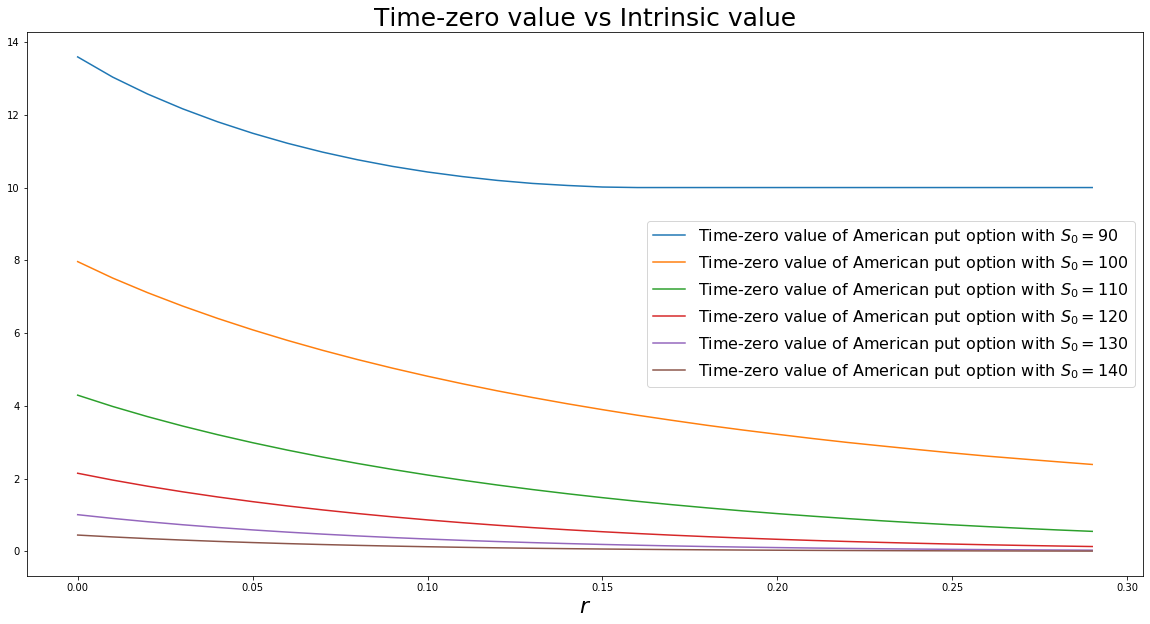

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
for j in range(8, 14):
  ax.plot(r_range, TrinomialPxs_r[j], label='Time-zero value of American put option with $S_0='+str(10*(j+1))+'$')
ax.set_xlabel('$r$', fontsize = 22)
ax.set_title('Time-zero value vs Intrinsic value', fontsize = 25)
ax.legend(fontsize = 16)